## **First install ludopy and Q-Learner Trained Agent**

---



In [1]:
!git clone https://github.com/arindammajee/A-Reinforcement-Learning-Approach-to-Ludo.git  # Q-Learning Trained Agent

Cloning into 'A-Reinforcement-Learning-Approach-to-Ludo'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 131 (delta 8), reused 13 (delta 5), pack-reused 112
Receiving objects: 100% (131/131), 7.71 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (53/53), done.


## Import ludopy and some others

In [1]:
import sys
import os
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Now import LudoPy and Q-Learn Trained Agent
dir="LUDOpy"
qlearn_dir = '/'.join(dir.split('/')[:-1])
sys.path.append(os.path.abspath(dir))
sys.path.append(os.path.abspath(os.path.join(qlearn_dir, 'src')))
import ludopy
from Qlearn import Qplayer

## Strategy and GUI Define

In [2]:
def strategy(pieces_that_can_move, player_pieces, enemy_pieces, dice):
  safe_positions = [1, 5, 9, 12, 18, 25]
  move_piece = -1
  if len(pieces_that_can_move)==0:
    return move_piece

  # Distance positions of enemy pieces
  distance_enemy_pieces = enemy_pieces[1] - 27

  # Promoting a token
  if move_piece==-1:
    for piece in pieces_that_can_move:
      if player_pieces[piece] + dice == 57:
        move_piece = piece
        return move_piece

  # Capture opponent
  if move_piece==-1:
    for piece in pieces_that_can_move:
      for enemy_pos in distance_enemy_pieces:
        dist = enemy_pos - player_pieces[piece]
        # Check if you can kill enemy
        if dist == dice:
          move_piece = piece
          return move_piece

  # Moving Token to a Safe Square
  if move_piece==-1:
    for piece in pieces_that_can_move:
      future_pos = player_pieces[piece] + dice
      if future_pos in safe_positions:
        move_piece = piece
        return move_piece

  # Moving the first piece
  if move_piece==-1:
    max_piece, max_dist = -1, -1
    for piece in pieces_that_can_move:
      if player_pieces[piece] > max_dist:
        max_piece = piece
        max_dist = player_pieces[piece]

    move_piece = max_piece
    return move_piece

  return move_piece


def gui_on(game, FIGURE_SIZE, SLEEP_TIME):
  enviroment_image_rgb = game.render_environment()  # RGB image of the enviroment
  #enviroment_image_bgr = cv2.cvtColor(enviroment_image_rgb, cv2.COLOR_RGB2BGR)
  clear_output(wait=True)
  figure = plt.figure(figsize=FIGURE_SIZE)
  plt.imshow(enviroment_image_rgb)
  plt.show()
  time.sleep(SLEEP_TIME)

## SETUP GLOBAL VARIABLES FOR GAMES SIMULATION

In [3]:
#####################################################################################################
## SETUP GLOBAL VARIABLES FOR GAMES SIMULATION
NUM_PLAYERS = 2 # Or 4
GUI = False
FIGURE_SIZE = (9.6, 7.2)  #In Inches. Try to keep the aspect ratio in 4:3
SLEEP_TIME = 2 # In Second. Wait time between two moves proper visualization
GAME_LENGTH = 10 #"FULL" # 24 or 36 or "FULL"

player_color_dict = {
    0: "GREEN (Bottom Left)",
    1: "YELLOW (Top Left)",
    2: "BLUE (Top Right)",
    3: "RED (Bottom Right)"
}
#####################################################################################################

## GAME Simulation Testing Function

In [4]:
## Simulation Testing Function
def GameSimulation(run_num=1, num_round=GAME_LENGTH, print_each_result=False, game_type=0, gui=False, figure_size=FIGURE_SIZE, wait_time=SLEEP_TIME, save_hist=False):
  player_2_type = {
    0: "Random Player",
    1: "Q-Learner Player"
  }
  print(f"We will simulate {run_num} game each for {num_round} rounds. These games will be Aggressive player vs {player_2_type[game_type]}")
  print(f"Player 0 (GREEN Pieces) is Aggressive player. Player 2 (BLUE Pieces) is {player_2_type[game_type]}")


  ## Winners List
  winners =[]
  start_time = time.time()

  for run in range(run_num):
    ## GAME Setup
    if NUM_PLAYERS==2:
      g = ludopy.Game(ghost_players=[1, 3])  # This will prevent players 1 and 3 from moving out of the start and thereby they are not in the game
    else:
      g = ludopy.Game()
    if game_type==1:
      player2 = Qplayer(tableName=os.path.join(qlearn_dir, 'src/Qs.txt'))

    there_is_a_winner = False
    while not there_is_a_winner:
      (dice, move_pieces, player_pieces, enemy_pieces, player_is_a_winner, there_is_a_winner), player_i = g.get_observation()
        #print(f"{player_i}: {dice}, {move_pieces}  {player_pieces}")
      if gui:
        gui_on(game=g, FIGURE_SIZE=figure_size, SLEEP_TIME=wait_time)

      if player_i==0:
        piece_to_move = strategy(move_pieces, player_pieces, enemy_pieces, dice)
      elif player_i==2:
        if game_type==0:
          if len(move_pieces):
            piece_to_move = move_pieces[np.random.randint(0, len(move_pieces))]
          else:
            piece_to_move = -1
        elif game_type==1:
          player2.nextmove(player_i, player_pieces, enemy_pieces, dice, move_pieces)
          piece_to_move = player2.piece

      _, _, _, _, _, there_is_a_winner = g.answer_observation(piece_to_move)

      if there_is_a_winner and GUI:
        gui_on(game=g, FIGURE_SIZE=FIGURE_SIZE, SLEEP_TIME=SLEEP_TIME)

      if num_round!="FULL":
        if g.hist[-1][-1]==num_round+1:
          break

    winner = g.get_winner_of_game()
    if winner==-1:
      points_list = g.points_list
      winner = points_list.index(max(points_list))

    if print_each_result:
      print(f"Winner is: Player-{winner} {player_color_dict[winner]}")
    if save_hist:
      print("Saving history to numpy file")
      g.save_hist(f"game_history_random.npy")
      print("Saving game video")
      g.save_hist_video(f"game_video_random.mp4")

    winners.append(winner)

  end_time = time.time()
  total_time = end_time - start_time
  print(f"No of Rounds: {num_round}, No of runs: {run_num}, Total time: {total_time:.3f} sec, Average time: {total_time/run_num:.3f} sec")
  aggressive_win, player2_winn = winners.count(0), winners.count(2)
  print(f"Aggressive won {aggressive_win} games out of {run_num} games. Winning percentage is: {aggressive_win/run_num:.3f}")
  print(f"{player_2_type[game_type]} won {player2_winn} games out of {run_num} games. Winning percentage is: {player2_winn/run_num:.3f}")
  return winners, player2_winn/run_num


## **Aggressive vs Q-Learning Win Percentage Determination**



In [ ]:
##########################################################################
## Play The GAME
##########################################################################
GUI = False
FIGURE_SIZE = (9.6, 7.2)  #In Inches. Try to keep the aspect ratio in 4:3
SLEEP_TIME = 2 # In Second. Wait time between two moves proper visualization
GAME_LENGTH = 12 #"FULL" # 24 or 36 or "FULL"

QWIN_PERCENTAGE_LIST = []
for i in range(1, 31):
  print(f"####################################### NUM_ROUNDS={i} #######################################")
  winners, qwin_per = GameSimulation(run_num=1000, num_round=i, print_each_result=False, game_type=1)
  QWIN_PERCENTAGE_LIST.append(qwin_per)
  print("\n")

####################################### NUM_ROUNDS=1 #######################################
We will simulate 1000 game each for 1 rounds. These games will be Aggressive player vs Q-Learner Player
Player 0 (GREEN Pieces) is Aggressive player. Player 2 (BLUE Pieces) is Q-Learner Player
No of Rounds: 1, No of runs: 1000, Total time: 3.351 sec, Average time: 0.003 sec
Aggressive won 554 games out of 1000 games. Winning percentage is: 0.554
Q-Learner Player won 446 games out of 1000 games. Winning percentage is: 0.446


####################################### NUM_ROUNDS=2 #######################################
We will simulate 1000 game each for 2 rounds. These games will be Aggressive player vs Q-Learner Player
Player 0 (GREEN Pieces) is Aggressive player. Player 2 (BLUE Pieces) is Q-Learner Player


Text(0, 0.5, 'Winning percentage of Strategic Player')

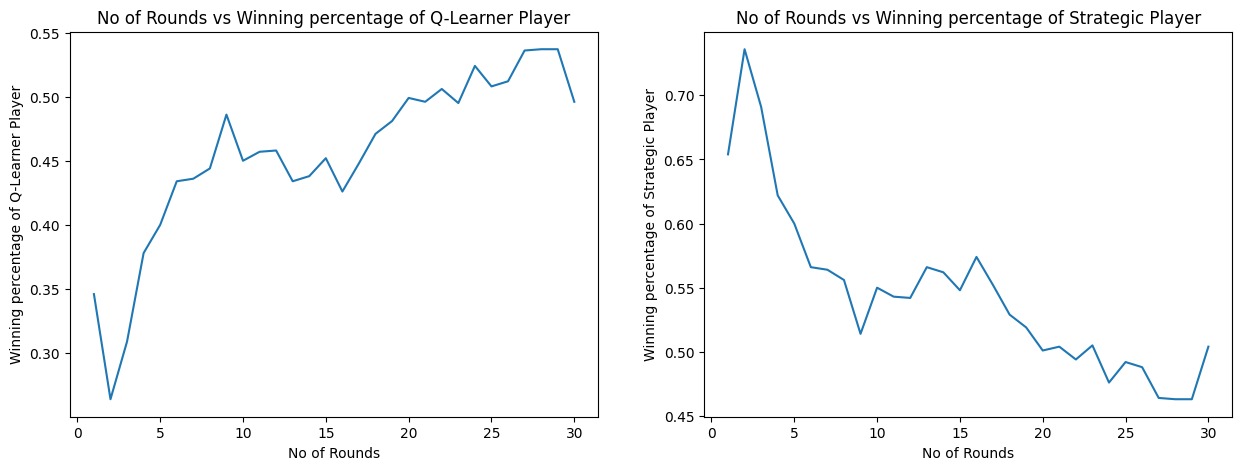

In [ ]:
rounds = np.arange(1, 31)
winning_percentage_qlearner = QWIN_PERCENTAGE_LIST
winning_percentage_aggressive = [1 - percentage for percentage in QWIN_PERCENTAGE_LIST]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(rounds, winning_percentage_qlearner)
ax[0].set_title("No of Rounds vs Winning percentage of Q-Learner Player")
ax[0].set_xlabel("No of Rounds")
ax[0].set_ylabel("Winning percentage of Q-Learner Player")

ax[1].plot(rounds, winning_percentage_aggressive)
ax[1].set_title("No of Rounds vs Winning percentage of Aggressive Player")
ax[1].set_xlabel("No of Rounds")
ax[1].set_ylabel("Winning percentage of Aggressive Player")

## **Aggressive vs Random Win Percentage Determination**



In [6]:
##########################################################################
## Play The GAME
##########################################################################
GUI = False
FIGURE_SIZE = (9.6, 7.2)  #In Inches. Try to keep the aspect ratio in 4:3
SLEEP_TIME = 2 # In Second. Wait time between two moves proper visualization
GAME_LENGTH = 12 #"FULL" # 24 or 36 or "FULL"

RANDOM_PERCENTAGE_LIST = []
for i in range(1, 31):
  print(f"####################################### NUM_ROUNDS={i} #######################################")
  winners, ranwin_per = GameSimulation(run_num=2000, num_round=i, print_each_result=False, game_type=0)
  RANDOM_PERCENTAGE_LIST.append(ranwin_per)
  print("\n")

####################################### NUM_ROUNDS=1 #######################################
We will simulate 2000 game each for 1 rounds. These games will be Aggressive player vs Random Player
Player 0 (GREEN Pieces) is Aggressive player. Player 2 (BLUE Pieces) is Random Player
No of Rounds: 1, No of runs: 2000, Total time: 2.360 sec, Average time: 0.001 sec
Aggressive won 1609 games out of 2000 games. Winning percentage is: 0.804
Random Player won 391 games out of 2000 games. Winning percentage is: 0.196


####################################### NUM_ROUNDS=2 #######################################
We will simulate 2000 game each for 2 rounds. These games will be Aggressive player vs Random Player
Player 0 (GREEN Pieces) is Aggressive player. Player 2 (BLUE Pieces) is Random Player
No of Rounds: 2, No of runs: 2000, Total time: 2.954 sec, Average time: 0.001 sec
Aggressive won 1534 games out of 2000 games. Winning percentage is: 0.767
Random Player won 466 games out of 2000 games. Win

Text(0, 0.5, 'Winning percentage of Aggressive Player')

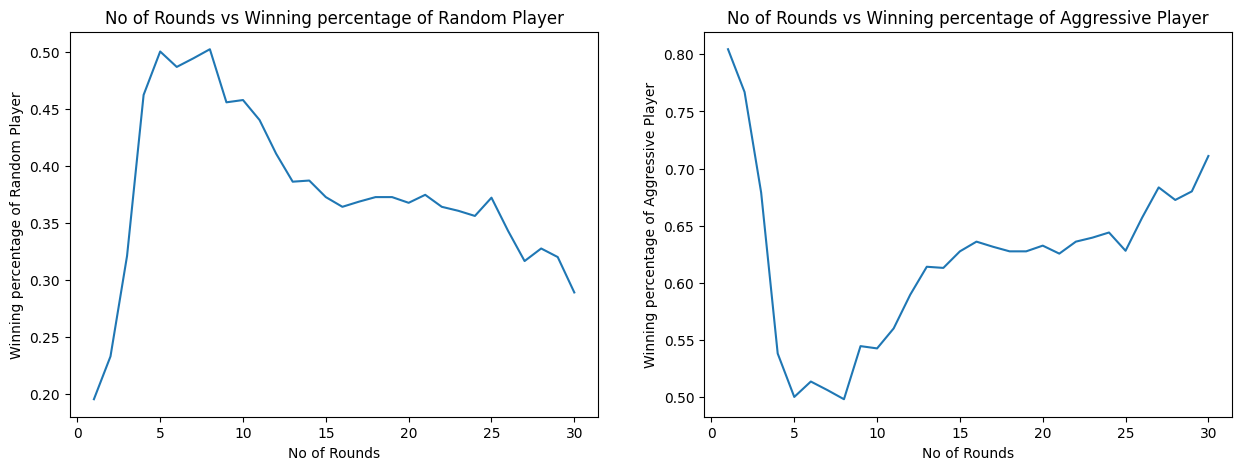

In [7]:
rounds = np.arange(1, 31)
winning_percentage_random = RANDOM_PERCENTAGE_LIST
winning_percentage_aggressive = [1 - percentage for percentage in RANDOM_PERCENTAGE_LIST]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(rounds, winning_percentage_random)
ax[0].set_title("No of Rounds vs Winning percentage of Random Player")
ax[0].set_xlabel("No of Rounds")
ax[0].set_ylabel("Winning percentage of Random Player")

ax[1].plot(rounds, winning_percentage_aggressive)
ax[1].set_title("No of Rounds vs Winning percentage of Aggressive Player")
ax[1].set_xlabel("No of Rounds")
ax[1].set_ylabel("Winning percentage of Aggressive Player")